In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
import time

from sklearn.model_selection import KFold
from keras.models import Model, Sequential
from keras import layers
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras import optimizers


In [2]:
from ipynb.fs.full.DatasetManage import read_and_store_data
from ipynb.fs.full.FeatureExtraction import feature_extraction
from ipynb.fs.full.ClassificationPerformanceIndexes import classificationPerformanceIndexes, printClassificationPerformanceIndexes
from ipynb.fs.full.ClassificationMethods import CompleteLSTM

Parameter

In [3]:
perfInd = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score', 'MCC', 'Kappa', 'Time']
channels = ['FP1-F7', 'F7-T7','T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'seizure']

dataset = 'CHB_MIT'
csvImportFile = 'CHB.csv'
csvExportFile = 'CHB.csv'
sample_rate = 256
time_window = 2
step = time_window * sample_rate

test_ratio = 0.3

pca_tolerance = 0.9

undersampling_rate = 0.2

oversampling_neighbors = 11

k_fold = 5

csvAverageFile = 'Features.csv'

batch = 10
epochs = 100
dropout_percentage = 0.2
loss_function = 'mean_squared_error'
metric = 'accuracy'

Create Training and Test Data

In [4]:
def trainTestData (features, test_ratio, k_fold, perfInd):
    x = features.loc[:, features.columns != 'seizure']
    y = features['seizure']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_ratio, shuffle = True)
    results = pd.DataFrame(columns = perfInd)
    kf = KFold(n_splits = k_fold, shuffle = True)
    return x_train, x_test, y_train, y_test, results, kf

Create training and validation and test data

In [65]:
def trainTestData_2 (features, perfInd):
    x = features.loc[:, features.columns != 'seizure']
    y = features['seizure']
    x_1, x_test, y_1, y_test = train_test_split(x, y, test_size = 0.3, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_1, y_1, test_size=0.2, random_state=42)
    results = pd.DataFrame(columns = perfInd)
    return x_train, x_test, y_train, y_test, x_val, y_val, results

Read and Store Data

In [5]:
print('Reading data from', csvImportFile)
df = pd.read_csv(csvImportFile, delimiter = ',', header = 0)

Reading data from CHB.csv


Feature Extraction 

In [10]:
# ft = feature_extraction(df, sample_rate, step, pca_tolerance, undersampling_rate, oversampling_neighbors)

Train and Test process

In [6]:
ft = pd.read_csv(csvAverageFile, delimiter = ',', header = 0)

Dataset splitting with K-fold validation

In [7]:
x_train, x_test, y_train, y_test, results, kf = trainTestData (ft, test_ratio, k_fold, perfInd)

x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
y_train = y_train.values.astype(int)
x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
y_test = y_test.values.astype(int)

print(np.shape(x_train))
print(np.shape(y_train))


(392, 1, 86)
(392,)


Dataset splitting with validation set

In [66]:
x_train, x_test, y_train, y_test, x_val, y_val, results = trainTestData_2 (ft, perfInd)

x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
y_train = y_train.values.astype(int)
x_val = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
y_val = y_test.values.astype(int)
x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
y_test = y_test.values.astype(int)

print(np.shape(x_train))
print(np.shape(y_train))

(313, 1, 86)
(313,)


In [ ]:
model = Sequential()
model.add(layers.Conv1D(8, 24, activation='relu', input_shape=(None, x_train.shape[-1])))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(8, 12, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(8, 6, activation='relu'))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit(x_train,
                    y_train,
                    steps_per_epoch=350,
                    epochs=20)

GRU

Epoch 1/180
63/63 [==============================] - 3s 10ms/step - loss: 2.5962 - accuracy: 0.5495 - val_loss: 2.0666 - val_accuracy: 0.5357
Epoch 2/180
63/63 [==============================] - 0s 4ms/step - loss: 2.1153 - accuracy: 0.6070 - val_loss: 1.2727 - val_accuracy: 0.7381
Epoch 3/180
63/63 [==============================] - 0s 4ms/step - loss: 1.4844 - accuracy: 0.7636 - val_loss: 0.9284 - val_accuracy: 0.8274
Epoch 4/180
63/63 [==============================] - 0s 4ms/step - loss: 0.9672 - accuracy: 0.8115 - val_loss: 0.7848 - val_accuracy: 0.8690
Epoch 5/180
63/63 [==============================] - 0s 4ms/step - loss: 0.6301 - accuracy: 0.8403 - val_loss: 0.5539 - val_accuracy: 0.9107
Epoch 6/180
63/63 [==============================] - 0s 4ms/step - loss: 0.4557 - accuracy: 0.8818 - val_loss: 0.3426 - val_accuracy: 0.9167
Epoch 7/180
63/63 [==============================] - 0s 4ms/step - loss: 0.3115 - accuracy: 0.9010 - val_loss: 0.3037 - val_accuracy: 0.9286
Epoch 8/180


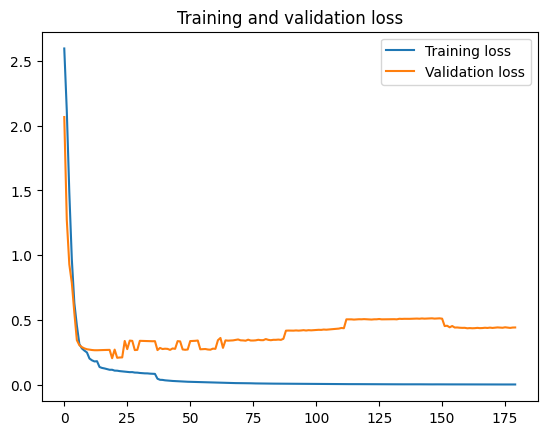

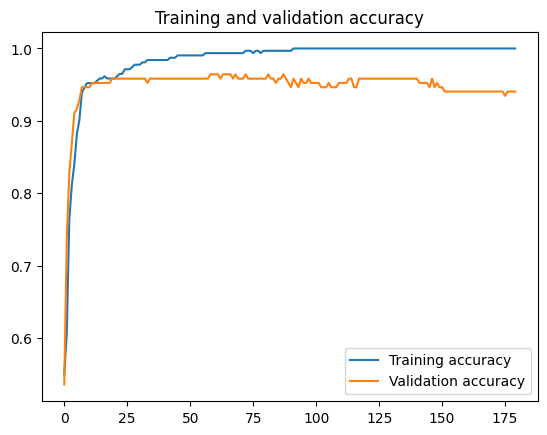

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_22 (GRU)                (None, 64)                29184     
                                                                 
 dense_42 (Dense)            (None, 1)                 65        
                                                                 
Total params: 29,249
Trainable params: 29,249
Non-trainable params: 0
_________________________________________________________________


In [78]:
model = Sequential()
model.add(layers.GRU(64, input_shape=(None, x_train.shape[-1])))
model.add(layers.Dense(1))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

"""
# Definisco l'ottimizzatore con il learning rate iniziale
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(learning_rate=initial_learning_rate)

# Definisco il learning rate schedule con decay lineare
decay_steps = 1000  # Numero di passi di addestramento dopo i quali applicare il decay
decay_rate = 0.1  # Tasso di decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

# Compilazione del modello
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) 
"""

# Addestramento del modello con il learning rate modificato

history = model.fit(x_train, y_train, epochs=180, validation_data=(x_val, y_val), batch_size=5)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(train_loss))

plt.figure()
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

model.summary()

Dropout

In [ ]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, x_train.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit(x_train,
                    y_train,
                    steps_per_epoch=500,
                    epochs=40)

# Plot 

loss = history.history['loss']
acc = history.history['acc']

epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, loss, label='Training accuracy')
plt.title('Training loss and accuracy with dropout')
plt.legend()

plt.show()

LSTM 

In [ ]:
lstm_units = 128
dense_units = 32  

CompleteLSTM(x_train, x_test, y_train, y_test, results, ft, kf, perfInd, epochs, batch, lstm_units, dense_units, dropout_percentage, loss_function, metric)

Vanilla RNN

Training

Epoch 1/200
40/40 [==============================] - 1s 8ms/step - loss: 0.7386 - accuracy: 0.5016 - val_loss: 0.7140 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 2/200
40/40 [==============================] - 0s 4ms/step - loss: 0.6617 - accuracy: 0.6166 - val_loss: 0.6502 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 3/200
40/40 [==============================] - 0s 4ms/step - loss: 0.6064 - accuracy: 0.6645 - val_loss: 0.5959 - val_accuracy: 0.7202 - lr: 0.0010
Epoch 4/200
40/40 [==============================] - 0s 3ms/step - loss: 0.5599 - accuracy: 0.7188 - val_loss: 0.5547 - val_accuracy: 0.7560 - lr: 0.0010
Epoch 5/200
40/40 [==============================] - 0s 3ms/step - loss: 0.5244 - accuracy: 0.7476 - val_loss: 0.5212 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 6/200
40/40 [==============================] - 0s 3ms/step - loss: 0.4957 - accuracy: 0.7732 - val_loss: 0.4940 - val_accuracy: 0.8214 - lr: 0.0010
Epoch 7/200
40/40 [==============================] - 0s 3ms/step - loss: 0.4

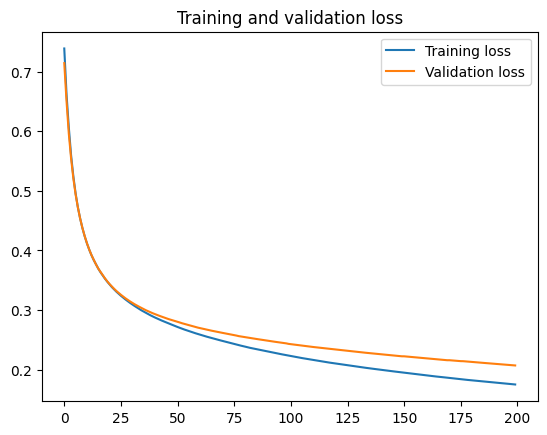

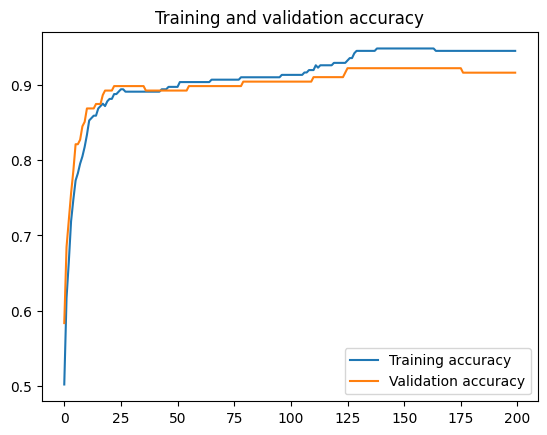

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_19 (SimpleRNN)   (None, 32)                3808      
                                                                 
 dense_30 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
_________________________________________________________________


In [64]:
# Definizione del modello RNN

model = Sequential()
model.add(SimpleRNN(32, input_shape=(None, x_train.shape[-1])))  # "timesteps" rappresenta il numero di istanti temporali nel segnale EEG, "features" è il numero di caratteristiche per ciascun istante temporale
model.add(Dense(1, activation='sigmoid'))

# Definisco l'ottimizzatore con il learning rate iniziale
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(learning_rate=initial_learning_rate)

# Definisco il learning rate schedule con decay lineare
decay_steps = 1000  # Numero di passi di addestramento dopo i quali applicare il decay
decay_rate = 0.1  # Tasso di decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

# Compilazione del modello
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# optimizer "adam"
# model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

# Addestramento del modello con il learning rate modificato
history = model.fit(x_train, y_train, epochs=200, batch_size=8, validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(train_loss))

plt.figure()
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

model.summary()

Evaluation of the model

In [27]:
# Valutazione del modello
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

4/4 [==============================] - 0s 6ms/step - loss: 0.1607 - accuracy: 0.9464
Test Loss: 0.1607215851545334
Test Accuracy: 0.9464285969734192


Dropout to prevent overfitting

Epoch 1/200
63/63 [==============================] - 1s 6ms/step - loss: 0.7326 - accuracy: 0.5783 - val_loss: 0.7008 - val_accuracy: 0.6369 - lr: 0.0010
Epoch 2/200
63/63 [==============================] - 0s 3ms/step - loss: 0.5972 - accuracy: 0.6965 - val_loss: 0.5763 - val_accuracy: 0.7321 - lr: 0.0010
Epoch 3/200
63/63 [==============================] - 0s 3ms/step - loss: 0.4781 - accuracy: 0.7764 - val_loss: 0.5086 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 4/200
63/63 [==============================] - 0s 3ms/step - loss: 0.4443 - accuracy: 0.8243 - val_loss: 0.4608 - val_accuracy: 0.7976 - lr: 0.0010
Epoch 5/200
63/63 [==============================] - 0s 3ms/step - loss: 0.4107 - accuracy: 0.8339 - val_loss: 0.4279 - val_accuracy: 0.8155 - lr: 0.0010
Epoch 6/200
63/63 [==============================] - 0s 3ms/step - loss: 0.3773 - accuracy: 0.8435 - val_loss: 0.4045 - val_accuracy: 0.8274 - lr: 0.0010
Epoch 7/200
63/63 [==============================] - 0s 3ms/step - loss: 0.3

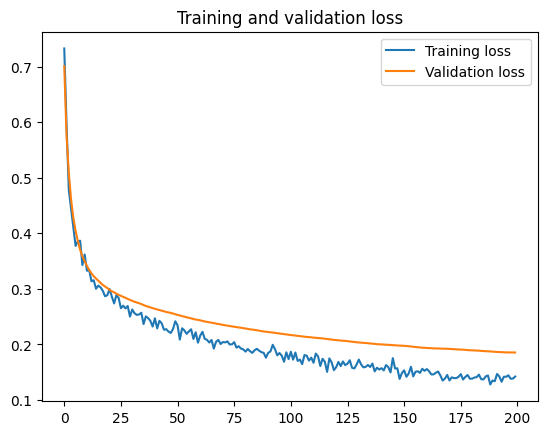

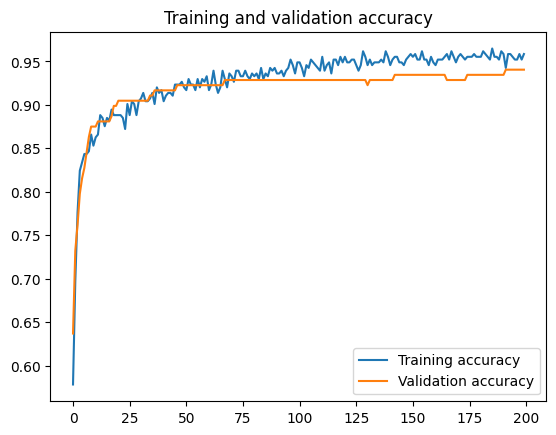

In [48]:
# Modello Vanilla RNN con dropout

model = Sequential()
model.add(SimpleRNN(32, input_shape=(None, x_train.shape[-1])))  # "timesteps" rappresenta il numero di istanti temporali nel segnale EEG, "features" è il numero di caratteristiche per ciascun istante temporale
model.add(Dropout(0.18))
model.add(Dense(1, activation='sigmoid'))

# Definisco l'ottimizzatore con il learning rate iniziale
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(learning_rate=initial_learning_rate)

# Definisco il learning rate schedule con decay lineare
decay_steps = 1000  # Numero di passi di addestramento dopo i quali applicare il decay
decay_rate = 0.1  # Tasso di decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

# Compilazione del modello
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Addestramento del modello
history = model.fit(x_train, y_train, epochs=200, batch_size=5, validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(train_loss))

plt.figure()
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [50]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_18 (SimpleRNN)   (None, 50)                6850      
                                                                 
 dropout_10 (Dropout)        (None, 50)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 51        
                                                                 
Total params: 6,901
Trainable params: 6,901
Non-trainable params: 0
_________________________________________________________________


Evaluation of the model after dropout

6/6 [==============================] - 0s 2ms/step - loss: 0.1855 - accuracy: 0.9405
Test Loss: 0.1854591816663742
Test Accuracy: 0.9404761791229248


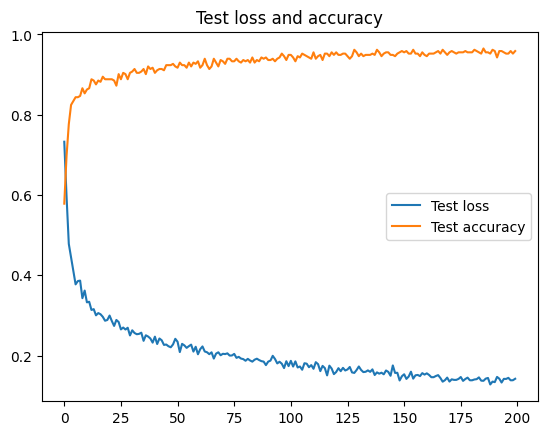

In [49]:
# Valutazione del modello
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

test_loss = history.history['loss']
test_acc = history.history['accuracy']

epochs = range(len(test_loss))

plt.figure()
plt.plot(epochs, test_loss, label='Test loss')
plt.plot(epochs, test_acc, label='Test accuracy')
plt.title('Test loss and accuracy')
plt.legend()

plt.show()

Vanilla RNN con K-fold cross validation

In [26]:
model = Sequential()
model.add(SimpleRNN(32, input_shape=(None, x_train.shape[-1])))  # "timesteps" rappresenta il numero di istanti temporali nel segnale EEG, "features" è il numero di caratteristiche per ciascun istante temporale
model.add(Dropout(0.18))
model.add(Dense(1, activation='sigmoid'))

# Definisco l'ottimizzatore con il learning rate iniziale
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(learning_rate=initial_learning_rate)

# Definisco il learning rate schedule con decay lineare
decay_steps = 1000  # Numero di passi di addestramento dopo i quali applicare il decay
decay_rate = 0.1  # Tasso di decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

# Compilazione del modello
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


"""
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
"""

k = 5  # numero di fold
kf = KFold(n_splits=k, shuffle = True)

# Array per memorizzare le curve di apprendimento
test_loss = []
test_acc = []

f = pd.DataFrame(columns = perfInd)
print('Implementing vanilla RNN with k-fold')
start = time.time()
for train, test in kf.split(ft):
    x_train = ft.iloc[train,:ft.shape[1]-1]
    x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
    y_train = ft.loc[train,'seizure'].values.astype(int)
    x_test = ft.iloc[test,:ft.shape[1]-1]
    x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
    y_test = ft.loc[test,'seizure'].values.astype(int)

    print(x_train.shape)
    print(x_test.shape)
    print(y_train.shape)
    print(y_test.shape)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size = 10, epochs = 100, verbose = 1, callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule)])
    # Valuta il modello
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    test_acc.append(accuracy)
    test_loss.append(loss)

    # Stampa i risultati di accuracy e loss per la k-esima fold
    print("Loss: {:.4f}, Accuracy: {:.2f}%".format(loss, accuracy * 100))

    # train_loss.append(history.history['loss'])
    # train_acc.append(history.history['accuracy'])

end = time.time()
t = round(end - start,2)
print('RNN finished in', t,'sec\n')

 # Calculate average performance
avg_accuracy = np.mean(test_acc)
avg_loss = np.mean(test_loss)
print(f'Average accuracy: {avg_accuracy:.4f}')
print(f'Average loss: {avg_loss:.4f}')



Implementing vanilla RNN with k-fold
(448, 1, 86)
(112, 1, 86)
(448,)
(112,)
Epoch 1/100
45/45 [==============================] - 1s 2ms/step - loss: 1.0969 - accuracy: 0.2857 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 0s 2ms/step - loss: 0.9034 - accuracy: 0.4464 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 0s 3ms/step - loss: 0.7942 - accuracy: 0.5536 - lr: 0.0010
Epoch 4/100
45/45 [==============================] - 0s 2ms/step - loss: 0.7041 - accuracy: 0.6116 - lr: 0.0010
Epoch 5/100
45/45 [==============================] - 0s 3ms/step - loss: 0.6234 - accuracy: 0.6652 - lr: 0.0010
Epoch 6/100
45/45 [==============================] - 0s 3ms/step - loss: 0.5856 - accuracy: 0.6875 - lr: 0.0010
Epoch 7/100
45/45 [==============================] - 0s 3ms/step - loss: 0.5222 - accuracy: 0.7277 - lr: 0.0010
Epoch 8/100
45/45 [==============================] - 0s 4ms/step - loss: 0.5103 - accuracy: 0.7366 - lr: 0.0010
Epoch 9/100
45/45 [========

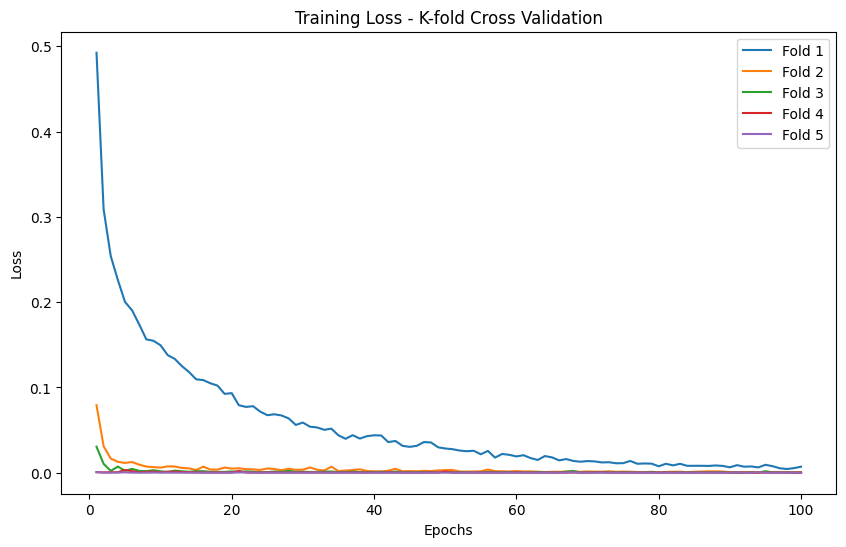

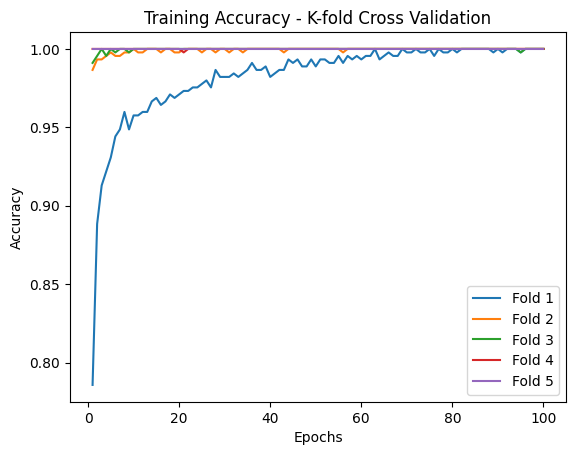

In [20]:
# Plot delle curve di apprendimento
epochs = range(1, len(train_loss[0]) + 1)
plt.figure(figsize=(10, 6))
for i in range(len(train_loss)):
    plt.plot(epochs, train_loss[i], label='Fold {}'.format(i+1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss - K-fold Cross Validation')
plt.legend()
plt.show()

plt.figure()

for i in range(len(train_loss)):
    plt.plot(epochs, train_acc[i], label='Fold {}'.format(i+1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy - K-fold Cross Validation')
plt.legend()
plt.show()
        


In [ ]:

# Plotting the results

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Early stopping

In [ ]:
# Modello Vanilla RNN con dropout e early stopping

model = Sequential()
model.add(SimpleRNN(32, input_shape=(None, x_train.shape[-1])))  # "timesteps" rappresenta il numero di istanti temporali nel segnale EEG, "features" è il numero di caratteristiche per ciascun istante temporale
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compilazione del modello
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Definizione dell'early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Addestramento del modello con early stopping
history = model.fit(x_train, y_train, epochs=200, batch_size=8, validation_data=(x_val, y_val), callbacks=[early_stopping])

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(train_loss))

plt.figure()
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()



Evaluation of the model with early stopping

In [ ]:
# Valutazione del modello
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

test_loss = history.history['loss']
test_acc = history.history['accuracy']

epochs = range(len(test_loss))

plt.figure()
plt.plot(epochs, test_loss, label='Test loss')
plt.plot(epochs, test_acc, label='Test accuracy')
plt.title('Test loss and accuracy')
plt.legend()

plt.show()